Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
def get_path(path):
  return 'gdrive/MyDrive/' + path + '/'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset - Done
data_dir_train = pathlib.Path(get_path('Train'))
data_dir_test = pathlib.Path(get_path('Test'))

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    seed=seed
) ##todo - Done

Found 6739 files belonging to 9 classes.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_width, img_height),
    seed=seed
) ##todo

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

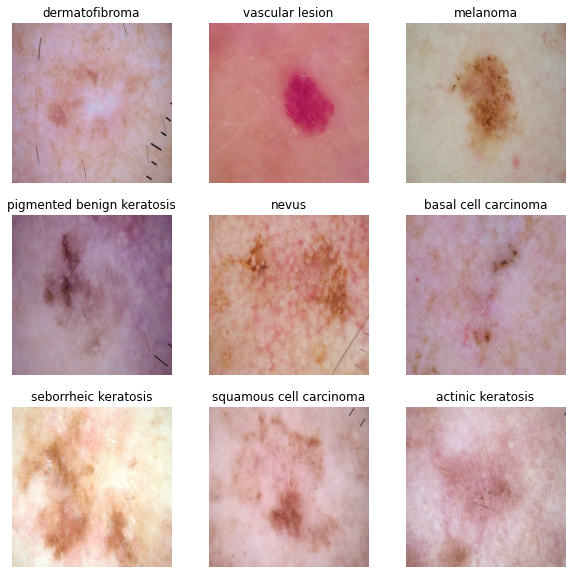

In [10]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
labels_taken=[]
for images, labels in train_ds.take(2):
  for i in range(32):
    if len(labels_taken) == num_classes:
      break
    if labels[i] not in labels_taken:
      ax = plt.subplot(3, 3, len(labels_taken)+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      labels_taken.append(labels[i])
            
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
211/211 [==============================] - 1378s 198ms/step - loss: 2.1785 - accuracy: 0.2059 - val_loss: 1.9599 - val_accuracy: 0.3220
Epoch 2/20
211/211 [==============================] - 4s 18ms/step - loss: 1.3434 - accuracy: 0.5109 - val_loss: 2.0277 - val_accuracy: 0.3475
Epoch 3/20
211/211 [==============================] - 4s 18ms/step - loss: 1.1115 - accuracy: 0.5898 - val_loss: 2.8676 - val_accuracy: 0.3559
Epoch 4/20
211/211 [==============================] - 4s 18ms/step - loss: 0.8739 - accuracy: 0.6808 - val_loss: 3.8618 - val_accuracy: 0.3390
Epoch 5/20
211/211 [==============================] - 4s 18ms/step - loss: 0.6158 - accuracy: 0.7758 - val_loss: 2.9365 - val_accuracy: 0.4153
Epoch 6/20
211/211 [==============================] - 4s 18ms/step - loss: 0.4663 - accuracy: 0.8330 - val_loss: 4.1387 - val_accuracy: 0.3814
Epoch 7/20
211/211 [==============================] - 4s 18ms/step - loss: 0.3511 - accuracy: 0.8764 - val_loss: 5.1722 - val_accuracy: 0.

### Visualizing training results

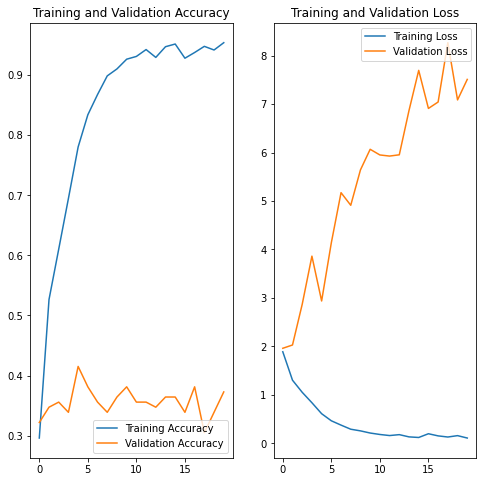

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
1. ## The model is overfitting as we can clearly see that the training accuracy is quite high in comparision to the validation accuracy
2. #### The maximum validation accuracy is around 40% and stays at the same, more or less

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

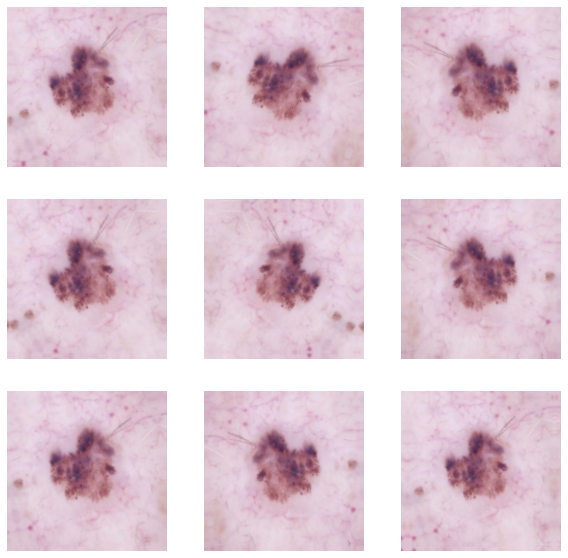

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) ## your training code

Epoch 1/20
211/211 [==============================] - 5s 21ms/step - loss: 2.0437 - accuracy: 0.2515 - val_loss: 2.0487 - val_accuracy: 0.3644
Epoch 2/20
211/211 [==============================] - 4s 20ms/step - loss: 1.4069 - accuracy: 0.4633 - val_loss: 2.0694 - val_accuracy: 0.3475
Epoch 3/20
211/211 [==============================] - 4s 20ms/step - loss: 1.3036 - accuracy: 0.5075 - val_loss: 1.9979 - val_accuracy: 0.3559
Epoch 4/20
211/211 [==============================] - 4s 20ms/step - loss: 1.2369 - accuracy: 0.5236 - val_loss: 1.9903 - val_accuracy: 0.3475
Epoch 5/20
211/211 [==============================] - 4s 20ms/step - loss: 1.1747 - accuracy: 0.5448 - val_loss: 2.2624 - val_accuracy: 0.3983
Epoch 6/20
211/211 [==============================] - 4s 20ms/step - loss: 1.1381 - accuracy: 0.5679 - val_loss: 1.8855 - val_accuracy: 0.4915
Epoch 7/20
211/211 [==============================] - 4s 20ms/step - loss: 1.0539 - accuracy: 0.5944 - val_loss: 2.3874 - val_accuracy: 0.3983

### Visualizing the results

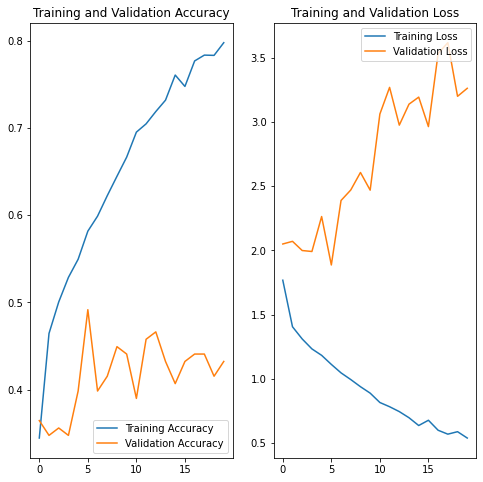

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. ## There is less overfitting; there is slight decrease in the difference between training and validation loss; there is a slight improvement. However, it can still be improved.
2. #### Due to the dropout, however, the maximum training accuracy has also gone down

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

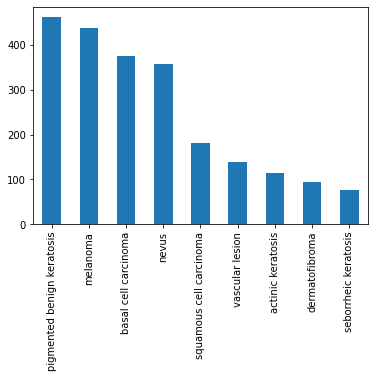

In [23]:
## Your code goes here.
df = pd.DataFrame(list(dict(zip([x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))], [os.path.basename(os.path.dirname(x)) for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))])).items()),columns = ['Path','Label'])
df['Label'].value_counts().plot(kind='bar');

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? - 
  ## **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples? - 
  ## **pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
path_to_training_dataset=get_path('Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F366D2D50>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3F8A4A0E50>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F8A366110>: 100%|██████████| 500/500 [00:18<00:00, 26.33 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F3F36757A50>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x676 at 0x7F3F366F7E50>: 100%|██████████| 500/500 [01:14<00:00,  6.67 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3F36773150>:   0%|          | 1/500 [00:00<00:55,  9.05 Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F36747490>: 100%|██████████| 500/500 [00:19<00:00, 25.82 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3F36747450>: 100%|██████████| 500/500 [00:40<00:00, 12.33 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F8A48A150>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3F3674B250>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]


In [26]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset - Done
data_dir_train = pathlib.Path(get_path('Train'))
data_dir_test = pathlib.Path(get_path('Test'))

In [27]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset - Done
data_dir_train = pathlib.Path(get_path('Train'))
data_dir_test = pathlib.Path(get_path('Test'))

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_bacbdb88-608f-4b34-9e85-1733885644d1.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_b26a68a4-94ee-4b59-9fa6-f319da5a2f37.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_770fe001-0487-484f-911b-f2ba2c576d1d.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027562.jpg_51839e22-8241-444a-a853-0291a80be88b.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_5d59b19d-0827-45a3-bf2c-7a4df06fa334.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025953.jpg_9a2b43ed-c820-4cb7-ad1e-59cea6a7a306.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027668.jpg_e3eeb5d5-b5c9-4fc0-a2c5-0b686a597ab5.jpg',
 'gdrive/MyDrive/Train/actinic keratosis/output/actinic

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [31]:
df_dict = dict(zip(path_list, lesion_list_new))

In [32]:
df_another = pd.DataFrame(list(df_dict.items()),columns = ['Path','Label'])
df_new = df.append(df_another)

In [33]:
df_new['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train = get_path('Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) # your model fit code

Epoch 1/50
281/281 [==============================] - 62s 213ms/step - loss: 1.9763 - accuracy: 0.2460 - val_loss: 1.4190 - val_accuracy: 0.4499
Epoch 2/50
281/281 [==============================] - 59s 206ms/step - loss: 1.4443 - accuracy: 0.4424 - val_loss: 1.2634 - val_accuracy: 0.4993
Epoch 3/50
281/281 [==============================] - 59s 207ms/step - loss: 1.3359 - accuracy: 0.4846 - val_loss: 1.2336 - val_accuracy: 0.5162
Epoch 4/50
281/281 [==============================] - 59s 205ms/step - loss: 1.2683 - accuracy: 0.5161 - val_loss: 1.5465 - val_accuracy: 0.4415
Epoch 5/50
281/281 [==============================] - 58s 203ms/step - loss: 1.2140 - accuracy: 0.5380 - val_loss: 1.2107 - val_accuracy: 0.5665
Epoch 6/50
281/281 [==============================] - 58s 204ms/step - loss: 1.1610 - accuracy: 0.5545 - val_loss: 0.9892 - val_accuracy: 0.6271
Epoch 7/50
281/281 [==============================] - 58s 203ms/step - loss: 1.0469 - accuracy: 0.5964 - val_loss: 0.9901 - val_ac

#### **Todo:**  Visualize the model results

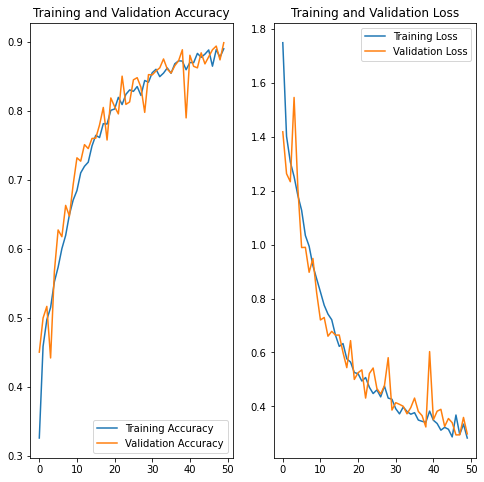

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. ## The validation accuracy went up from ~40% to 80+%
2. ## Reducing the class imbalance proved to be quite beneficial to reduce overfitting